# Data Driven Models in Engineering - Assignment 2

**Konstantinos Papadakis**

Masters program in Data Science and Machine Learning, National Technical University of Athens

Student Number: 03400149

email: k.i.papadakis@gmail.com, konstantinospapadakis@mail.ntua.gr

## Assignment Description

Consider a rectangular plate of dimensions $1m \times 1m$. There is a candle located at position $(0.55,0.45)$ below the plate which heats it. The steady state equation that describes the temperature field $T(x,y)$ along the plate at thermal equilibrium is:
$$-\left( \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} \right) = f(x, y)$$
where $f(x,y)$ is the external heat source due the candle, given by:
$$f(x, y) = 100 \cdot \exp\left(-\frac{(x - 0.55)^2 + (y - 0.45)^2}{r}\right) $$
with $r \sim \mathcal{N}(0.05, 0.005)$ being a normal random variable.

At all edges of the plate we assign $T = 0$ (Dirichlet Boundary conditions).

### Statement 1

Discretize the plate using a $40 \times 40$ grid, with $h=Δx=Δy=1/40$. Using the following second-order central difference approximation to 2<sup>nd</sup> derivatives	
$$\begin{align*}
	\frac{\partial^2 T}{\partial x^2} &\approx \frac{T(x+h, y) - 2T(x, y) + T(x-h, y)}{h^2}\\
	\frac{\partial^2 T}{\partial y^2} &\approx \frac{T(x, y+h) - 2T(x, y) + T(x, y-h)}{h^2}
\end{align*}
$$
you can get the finite difference scheme:
$$-T(x+h,y)-T(x,y+h)+4T(x,y)-T(x-h,y)-T(x,y-h) \approx h^2 f(x,y)$$

Derive the linear system of equations $Kx=b$ for the problem. (Comment: Instead of this scheme, you can use quadrilateral finite elements to derive a linear system for this problem, or any other scheme of your choice.)

### Statement 2

Perform Monte Carlo simulation to obtain the probability density function of the temperature at the midpoint of the plate $(0.5, 0.5)$.

### Statement 3

Perform a small number of deterministic simulations for different values of $r$, and use these solutions as your initial data set. Implement the PCA/POD method to reduce the dimensionality of the linear system that describes the problem and perform the Monte Carlo simulation on the reduced system. Compare the pdf of $T$ at point $(0.5, 0.5)$ to the one from the previous question.


## Assignment Answers

### Answer 1

We discretize the plate by using step $h = \frac{1}{40}$, resulting in a $41 \times 41$ grid.

The borders of the square have known final temperatures ($=0$), therefore we can ignore them, solve for the inner $39 \times 39$ grid, and then pad the solution with those already known borders.

We then proceed to create a $(39 \cdot 39) \times (39 \cdot 39)$ matrix $K$ to numerically approximate the solution to the differential equation using second order central differences.
We choose a sparse format for $K$ since each row only has $\leq 5$ non zero elements out of the $39 \cdot 39$ total.


In [63]:
import numpy as np
from scipy.sparse import lil_array, issparse
from scipy.sparse.linalg import spsolve
from scipy.linalg import solve, svd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


RANDOM_STATE = 42

In [2]:
def get_connection_matrix(
    m, n,
    self_weight=4.0 * 40**2,
    other_weight=-1.0 * 40**2,
    directions=((0,1), (0, -1), (1, 0), (-1, 0)),
):
    conmat = lil_array((m*n, m*n), dtype=np.float64)
    conmat.setdiag(self_weight)
    for i in range(m):
        for j in range(n):
            for a, b in directions:
                k, l = i+a, j+b
                if 0 <= k < m and 0 <= l < n:
                    x = i*n + j
                    y = k*n + l
                    conmat[x, y] = other_weight
    return conmat.tocsr()


conmat = get_connection_matrix(39, 39)

We then generate an instance of heat source values and compute an approximate solution using our discretization method. 

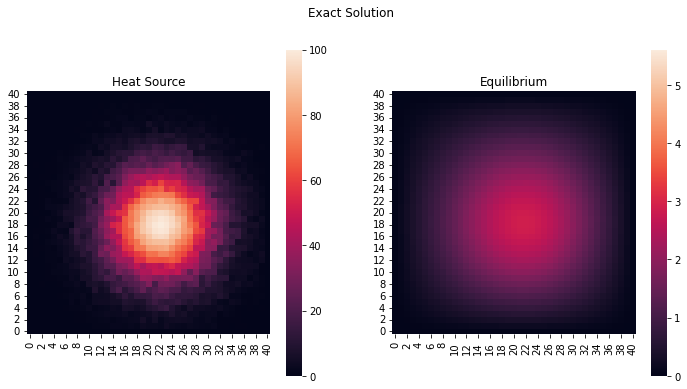

In [5]:
def external_heat_func(x, y, mu, sigma, seed=None):
    assert np.shape(x) == np.shape(y)
    shape = np.shape(x)
    rng = np.random.default_rng(seed)
    r = rng.normal(mu, sigma, shape)
    val = 100 * np.exp(
        -((x - 0.55)**2 + (y - 0.45)**2) / r
    )
    return val


def get_temperatures(minval, maxval, step, mu=0.05, sigma=0.005, seed=None):
    xvals = yvals = np.arange(minval+step, maxval, step)  # h, 2h, ... 1-h
    x_mesh, y_mesh = np.meshgrid(xvals, yvals)
    z = external_heat_func(x_mesh, y_mesh, mu, sigma, seed=seed)
    return z.flatten(order='C')


def solve_system(conmat, temps, pca: None | np.ndarray = None):
    if pca is not None:
        conmat = pca.T @ conmat @ pca
        temps = pca.T @ temps
    
    if issparse(conmat):
        solution = spsolve(conmat, temps)
    else:
        solution = solve(conmat, temps)
        
    if pca is not None:
        solution = pca @ solution
    
    solution = solution.T
    assert solution.shape[-1] == 39*39
    solution = solution.reshape(-1, 39, 39)
    solution = np.pad(solution, ((0, 0), (1, 1), (1, 1)))
    
    if solution.shape[0] == 1:
        solution = np.squeeze(solution, 0)
        
    return solution


def plot_solution(temps, solution, title=None):
    fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
    
    sns.heatmap(
        np.pad(temps.reshape(39, 39), ((1,1), (1, 1))),
        cmap='rocket', square=True,
        vmin=0, vmax=np.max(temps),
        ax=axs[0]
    )
    sns.heatmap(
        solution,
        cmap='rocket', square=True,
        vmin=0,
        vmax=2 / (1/np.max(solution) + 1/np.max(temps)),
        ax=axs[1]
    )
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[0].set_title('Heat Source')
    axs[1].set_title('Equilibrium')
    fig.suptitle(title)
    
    return axs


t = get_temperatures(0, 1, 1/40, seed=RANDOM_STATE)
solution = solve_system(conmat, t)
plot_solution(t, solution, title='Exact Solution')
plt.show()

### Answer 2

We perform a Monte Carlo simulation for the equilibrium value at the midpoint $(0.5, 0.5)$ of the plate.

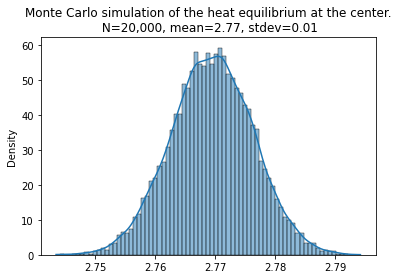

In [37]:
def monte_carlo(n_samples, conmat, pca: None | np.ndarray = None, seed=None):
    seeds = range(seed, seed + n_samples) if seed is not None else [None] * n_samples
    
    temps = []
    for i in range(n_samples):
        t = get_temperatures(0, 1, 1/40, seed=seeds[i])
        temps.append(t)
    temps = np.array(temps)
    
    solutions = solve_system(conmat, temps.T, pca=pca)
    return solutions


def plot_density(samples, title=None, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    
    sns.histplot(samples, kde=True, stat='density', ax=ax)
    ax.set_title(
        ('' if title is None else title + ' ')
        + f'N={len(samples):,}, '
        f'mean={samples.mean():.2f}, '
        f'stdev={samples.std():.2f}'
    )
    return ax


# MONTE CARLO (EXACT)
n_samples = 20_000
assert n_samples > 39 * 39  # For later in PCA: heat source samples > dim heat source
samples = monte_carlo(n_samples, conmat, seed=RANDOM_STATE)
c1 = (samples.shape[-2] + 1) // 2
c2 = (samples.shape[-1] + 1) // 2
center_samples = samples[..., c1, c2]
plot_density(
    center_samples,
    title='Monte Carlo simulation of the heat equilibrium at the center.\n'
)
plt.show()

Observe that the density seems to be roughly normal. We test our observation by using various normality tests.

In [94]:
# Selecting a smaller sample because when the sample size is above 5,000
# the test can become inaccurate (scipy actually displays a warning about it)
rng = np.random.default_rng(RANDOM_STATE)
subset = rng.choice(center_samples, size=500, replace=False)
norm = stats.distributions.norm(loc=subset.mean(), scale=subset.std())
dagostino_pearson = stats.normaltest(subset)
shapiro_wilk = stats.shapiro(subset)
kolmogorov_smirnov = stats.kstest(subset, norm.cdf, N=20)
alpha = 0.05
print(
    f"Normality tests for the distribution of heat at the midpoint (significance level = {alpha})"
    f"\nD'Agostino-Pearson test p-value\t{dagostino_pearson.pvalue: .6f}"
    f"\tNormality Hypothesis {'rejected' if dagostino_pearson.pvalue < alpha else 'not rejected'}"
    f"\nShapiro-Wilk test p-value      \t{shapiro_wilk.pvalue: .6f}"
    f"\tNormality Hypothesis {'rejected' if shapiro_wilk.pvalue < alpha else 'not rejected'}"
    f"\nKolmogorov-Smirnov test p-value\t{kolmogorov_smirnov.pvalue: .6f}"
    f"\tNormality Hypothesis {'rejected' if kolmogorov_smirnov.pvalue < alpha else 'not rejected'}"
)


Normality tests for the distribution of heat at the midpoint (significance level = 0.05)
D'Agostino-Pearson test p-value	 0.330223	Normality Hypothesis not rejected
Shapiro-Wilk test p-value      	 0.546157	Normality Hypothesis not rejected
Kolmogorov-Smirnov test p-value	 0.936589	Normality Hypothesis not rejected


### Answer 3

In [ ]:



def get_pca(X):
    n, p = X.shape
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X = (X - mean) / std
    U, S, Vt = svd(X, full_matrices=False)
    eigvals = S**2 / (n - 1)
    eigvecs = Vt.T
    return eigvals, eigvecs


def plot_explained_variance(ratio_cumsum, n_components):
    point = n_components, ratio_cumsum[n_components - 1]
    xs = range(1, 1 + len(ratio_cumsum))
    
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(xs, ratio_cumsum)
    ax.plot(*point, 'ro', label=f'({point[0]+1: d}, {point[1]: .2f})')
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Explained Variance Ratio')
    ax.legend(loc='best')
    ax.set_title('PCA')
    
    return ax





def plot_exact_vs_pca(samples_exact, samples_pca):
    fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
    plot_density(samples_exact, title='Exact Solutions', ax=axs[0])
    plot_density(samples_pca, title=f'PCA Solutions', ax=axs[1])
    fig.suptitle('Monte Carlo simulation of the heat equilibrium at the center.')
    return axs



In [ ]:
# PCA
samples_flat = samples[:, 1:-1, 1:-1]
samples_flat = samples_flat.reshape(samples.shape[0], -1)

eigvals, eigvecs = get_pca(samples_flat)
explained_var = eigvals / np.sum(eigvals)
ratio_cumsum = np.cumsum(explained_var)
thresh = 0.99
n_components = 1 + np.searchsorted(ratio_cumsum, thresh, side="right")
plot_explained_variance(ratio_cumsum, n_components)
plt.savefig('output/explained-var.png', facecolor='white', transparent=False)


In [ ]:
# MONTE CARLO (PCA)
samples_alt = monte_carlo(n_samples, conmat, pca=eigvecs[:, :n_components], seed=RANDOM_STATE)
center_samples_pca = samples_alt[:, c1, c2]
plot_exact_vs_pca(center_samples, center_samples_pca)
plt.savefig('output/dists-exact-pca.png', facecolor='white', transparent=False)
